In [1]:
from luwiji.rnn import illustration

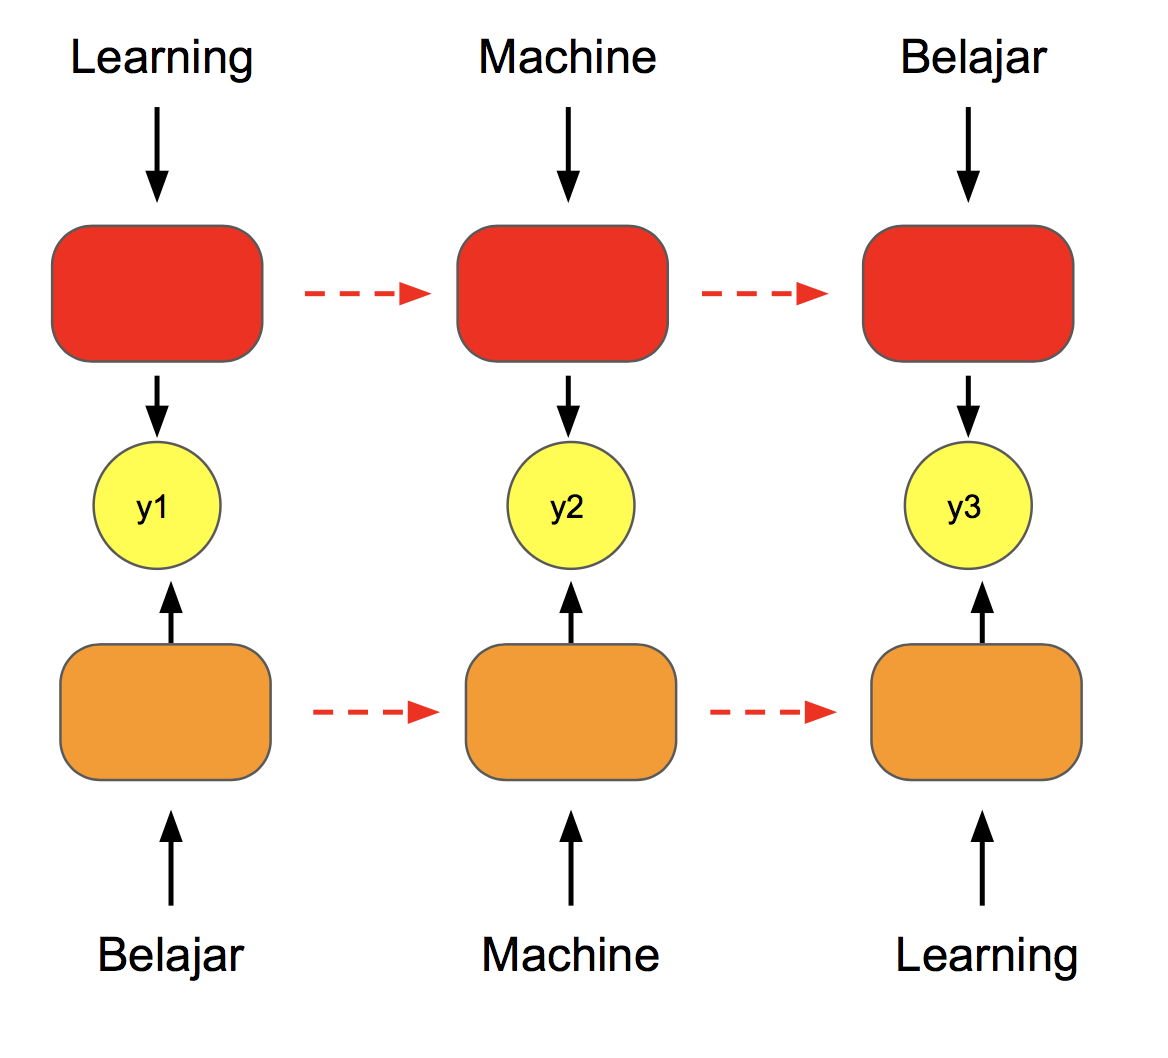

In [2]:
illustration.blstm

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


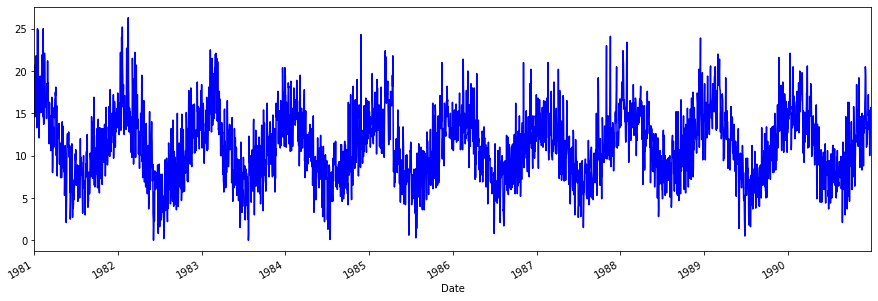

In [6]:
df.Temp.plot(figsize=(15, 5), color='b')

## Dataset Splitting

In [7]:
# X = df.Temp
# y = df.Temp

ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset & Dataloader

In [8]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [9]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



## Arsitektur & Config

In [10]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
        

In [11]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

## Training Preparation -> MCOC

In [23]:
model = BiLSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model/bilstm")

## Training

In [24]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 137.0750 | Test_cost  = 144.4517 | 




Epoch     2
Train_cost  = 135.1571 | Test_cost  = 142.4060 | 




Epoch     3
Train_cost  = 133.1553 | Test_cost  = 140.2379 | 




Epoch     4
Train_cost  = 131.0098 | Test_cost  = 137.8731 | 




Epoch     5
Train_cost  = 128.6422 | Test_cost  = 135.2204 | 




Epoch     6
Train_cost  = 125.9598 | Test_cost  = 132.1778 | 




Epoch     7
Train_cost  = 122.8608 | Test_cost  = 128.6373 | 




Epoch     8
Train_cost  = 119.2408 | Test_cost  = 124.4952 | 




Epoch     9
Train_cost  = 115.0052 | Test_cost  = 119.6695 | 




Epoch    10
Train_cost  = 110.0905 | Test_cost  = 114.1257 | 




Epoch    11
Train_cost  = 104.4913 | Test_cost  = 107.9085 | 




Epoch    12
Train_cost  = 98.2948 | Test_cost  = 101.1830 | 




Epoch    13
Train_cost  = 91.7192 | Test_cost  = 94.2639 | 




Epoch    14
Train_cost  = 85.1117 | Test_cost  = 87.5452 | 




Epoch    15
Train_cost  = 78.8270 | Test_cost  = 81.3082 | 




Epoch    16
Train_cost  = 73.0598 | Test_cost  = 75.6318 | 




Epoch    17
Train_cost  = 67.8367 | Test_cost  = 70.4893 | 




Epoch    18
Train_cost  = 63.1220 | Test_cost  = 65.8408 | 




Epoch    19
Train_cost  = 58.8771 | Test_cost  = 61.6508 | 




Epoch    20
Train_cost  = 55.0654 | Test_cost  = 57.8812 | 


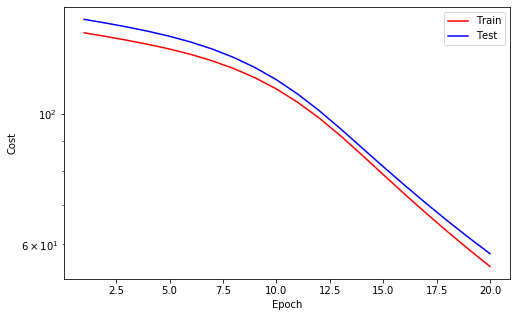



Epoch    21
Train_cost  = 51.6467 | Test_cost  = 54.4892 | 




Epoch    22
Train_cost  = 48.5785 | Test_cost  = 51.4321 | 




Epoch    23
Train_cost  = 45.8208 | Test_cost  = 48.6733 | 




Epoch    24
Train_cost  = 43.3402 | Test_cost  = 46.1824 | 




Epoch    25
Train_cost  = 41.1079 | Test_cost  = 43.9320 | 




Epoch    26
Train_cost  = 39.0975 | Test_cost  = 41.8962 | 




Epoch    27
Train_cost  = 37.2845 | Test_cost  = 40.0518 | 




Epoch    28
Train_cost  = 35.6471 | Test_cost  = 38.3787 | 




Epoch    29
Train_cost  = 34.1669 | Test_cost  = 36.8600 | 




Epoch    30
Train_cost  = 32.8280 | Test_cost  = 35.4810 | 




Epoch    31
Train_cost  = 31.6165 | Test_cost  = 34.2280 | 




Epoch    32
Train_cost  = 30.5189 | Test_cost  = 33.0869 | 




Epoch    33
Train_cost  = 29.5214 | Test_cost  = 32.0438 | 




Epoch    34
Train_cost  = 28.6114 | Test_cost  = 31.0863 | 




Epoch    35
Train_cost  = 27.7780 | Test_cost  = 30.2042 | 




Epoch    36
Train_cost  = 27.0118 | Test_cost  = 29.3886 | 




Epoch    37
Train_cost  = 26.3051 | Test_cost  = 28.6325 | 




Epoch    38
Train_cost  = 25.6519 | Test_cost  = 27.9303 | 




Epoch    39
Train_cost  = 25.0473 | Test_cost  = 27.2777 | 




Epoch    40
Train_cost  = 24.4874 | Test_cost  = 26.6712 | 


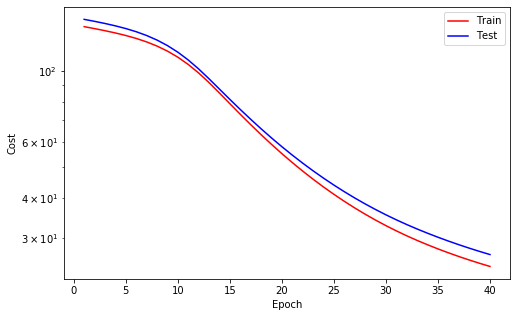



Epoch    41
Train_cost  = 23.9691 | Test_cost  = 26.1074 | 




Epoch    42
Train_cost  = 23.4892 | Test_cost  = 25.5833 | 




Epoch    43
Train_cost  = 23.0445 | Test_cost  = 25.0955 | 




Epoch    44
Train_cost  = 22.6322 | Test_cost  = 24.6408 | 




Epoch    45
Train_cost  = 22.2490 | Test_cost  = 24.2162 | 




Epoch    46
Train_cost  = 21.8925 | Test_cost  = 23.8190 | 




Epoch    47
Train_cost  = 21.5603 | Test_cost  = 23.4469 | 




Epoch    48
Train_cost  = 21.2503 | Test_cost  = 23.0979 | 




Epoch    49
Train_cost  = 20.9606 | Test_cost  = 22.7700 | 




Epoch    50
Train_cost  = 20.6897 | Test_cost  = 22.4618 | 




Epoch    51
Train_cost  = 20.4360 | Test_cost  = 22.1717 | 




Epoch    52
Train_cost  = 20.1984 | Test_cost  = 21.8985 | 




Epoch    53
Train_cost  = 19.9755 | Test_cost  = 21.6409 | 




Epoch    54
Train_cost  = 19.7664 | Test_cost  = 21.3979 | 




Epoch    55
Train_cost  = 19.5701 | Test_cost  = 21.1685 | 




Epoch    56
Train_cost  = 19.3856 | Test_cost  = 20.9518 | 




Epoch    57
Train_cost  = 19.2122 | Test_cost  = 20.7470 | 




Epoch    58
Train_cost  = 19.0490 | Test_cost  = 20.5532 | 




Epoch    59
Train_cost  = 18.8954 | Test_cost  = 20.3696 | 




Epoch    60
Train_cost  = 18.7506 | Test_cost  = 20.1956 | 


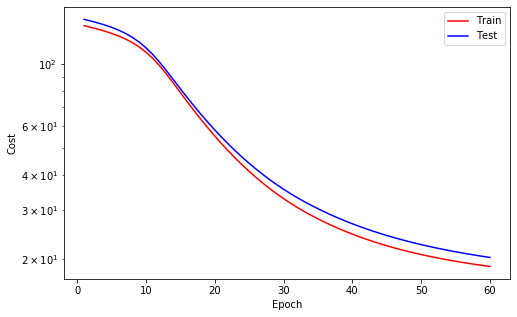



Epoch    61
Train_cost  = 18.6138 | Test_cost  = 20.0302 | 




Epoch    62
Train_cost  = 18.4845 | Test_cost  = 19.8727 | 




Epoch    63
Train_cost  = 18.3617 | Test_cost  = 19.7221 | 




Epoch    64
Train_cost  = 18.2446 | Test_cost  = 19.5772 | 




Epoch    65
Train_cost  = 18.1323 | Test_cost  = 19.4373 | 




Epoch    66
Train_cost  = 18.0246 | Test_cost  = 19.3028 | 




Epoch    67
Train_cost  = 17.9219 | Test_cost  = 19.1749 | 




Epoch    68
Train_cost  = 17.8251 | Test_cost  = 19.0546 | 




Epoch    69
Train_cost  = 17.7343 | Test_cost  = 18.9413 | 




Epoch    70
Train_cost  = 17.6487 | Test_cost  = 18.8341 | 




Epoch    71
Train_cost  = 17.5674 | Test_cost  = 18.7323 | 




Epoch    72
Train_cost  = 17.4897 | Test_cost  = 18.6351 | 




Epoch    73
Train_cost  = 17.4149 | Test_cost  = 18.5418 | 




Epoch    74
Train_cost  = 17.3428 | Test_cost  = 18.4524 | 




Epoch    75
Train_cost  = 17.2737 | Test_cost  = 18.3670 | 




Epoch    76
Train_cost  = 17.2073 | Test_cost  = 18.2846 | 




Epoch    77
Train_cost  = 17.1427 | Test_cost  = 18.2044 | 




Epoch    78
Train_cost  = 17.0793 | Test_cost  = 18.1260 | 




Epoch    79
Train_cost  = 17.0170 | Test_cost  = 18.0495 | 




Epoch    80
Train_cost  = 16.9555 | Test_cost  = 17.9752 | 


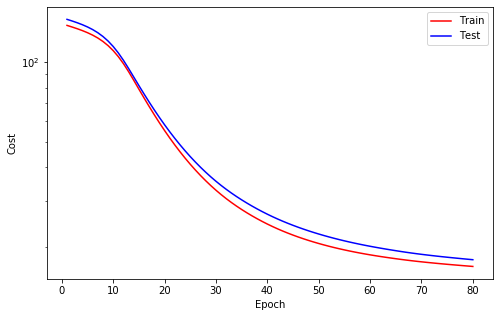



Epoch    81
Train_cost  = 16.8947 | Test_cost  = 17.9026 | 




Epoch    82
Train_cost  = 16.8338 | Test_cost  = 17.8312 | 




Epoch    83
Train_cost  = 16.7717 | Test_cost  = 17.7601 | 




Epoch    84
Train_cost  = 16.7075 | Test_cost  = 17.6883 | 




Epoch    85
Train_cost  = 16.6402 | Test_cost  = 17.6149 | 




Epoch    86
Train_cost  = 16.5686 | Test_cost  = 17.5389 | 




Epoch    87
Train_cost  = 16.4914 | Test_cost  = 17.4589 | 




Epoch    88
Train_cost  = 16.4064 | Test_cost  = 17.3715 | 




Epoch    89
Train_cost  = 16.3087 | Test_cost  = 17.2688 | 




Epoch    90
Train_cost  = 16.1846 | Test_cost  = 17.1256 | 




Epoch    91
Train_cost  = 15.9943 | Test_cost  = 16.8789 | 




Epoch    92
Train_cost  = 15.7715 | Test_cost  = 16.7155 | 




Epoch    93
Train_cost  = 15.6518 | Test_cost  = 16.5986 | 




Epoch    94
Train_cost  = 15.5276 | Test_cost  = 16.4801 | 




Epoch    95
Train_cost  = 15.4087 | Test_cost  = 16.3563 | 




Epoch    96
Train_cost  = 15.2812 | Test_cost  = 16.2249 | 




Epoch    97
Train_cost  = 15.1472 | Test_cost  = 16.0818 | 




Epoch    98
Train_cost  = 14.9972 | Test_cost  = 15.9137 | 




Epoch    99
Train_cost  = 14.8153 | Test_cost  = 15.6949 | 




Epoch   100
Train_cost  = 14.6105 | Test_cost  = 15.4925 | 


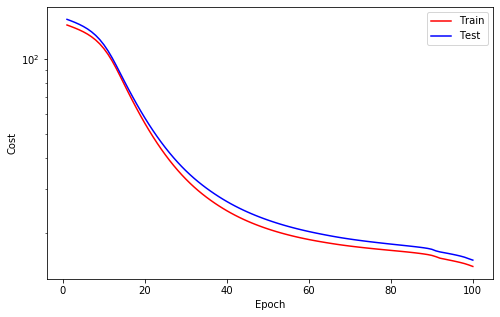



Epoch   101
Train_cost  = 14.4247 | Test_cost  = 15.2832 | 




Epoch   102
Train_cost  = 14.1820 | Test_cost  = 14.9795 | 




Epoch   103
Train_cost  = 13.7666 | Test_cost  = 14.4170 | 




Epoch   104
Train_cost  = 13.1653 | Test_cost  = 13.8081 | 




Epoch   105
Train_cost  = 12.6599 | Test_cost  = 13.3467 | 




Epoch   106
Train_cost  = 12.3350 | Test_cost  = 13.0221 | 




Epoch   107
Train_cost  = 12.0791 | Test_cost  = 12.7502 | 




Epoch   108
Train_cost  = 11.8614 | Test_cost  = 12.5128 | 




Epoch   109
Train_cost  = 11.6577 | Test_cost  = 12.2910 | 




Epoch   110
Train_cost  = 11.4528 | Test_cost  = 12.0562 | 




Epoch   111
Train_cost  = 11.2440 | Test_cost  = 11.8320 | 




Epoch   112
Train_cost  = 11.0528 | Test_cost  = 11.6356 | 




Epoch   113
Train_cost  = 10.8750 | Test_cost  = 11.4520 | 




Epoch   114
Train_cost  = 10.7096 | Test_cost  = 11.2759 | 




Epoch   115
Train_cost  = 10.5547 | Test_cost  = 11.1030 | 




Epoch   116
Train_cost  = 10.4062 | Test_cost  = 10.9350 | 




Epoch   117
Train_cost  = 10.2640 | Test_cost  = 10.7766 | 




Epoch   118
Train_cost  = 10.1280 | Test_cost  = 10.6262 | 




Epoch   119
Train_cost  = 9.9974 | Test_cost  = 10.4775 | 




Epoch   120
Train_cost  = 9.8706 | Test_cost  = 10.3321 | 


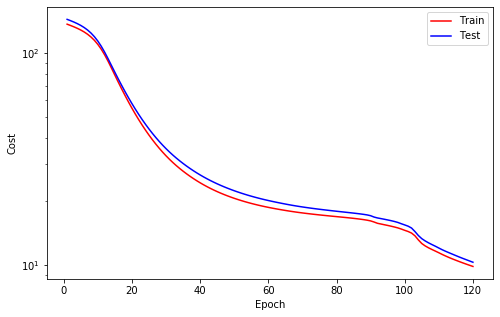



Epoch   121
Train_cost  = 9.7484 | Test_cost  = 10.1892 | 




Epoch   122
Train_cost  = 9.6300 | Test_cost  = 10.0492 | 




Epoch   123
Train_cost  = 9.5154 | Test_cost  = 9.9126 | 




Epoch   124
Train_cost  = 9.4031 | Test_cost  = 9.7813 | 




Epoch   125
Train_cost  = 9.2939 | Test_cost  = 9.6537 | 




Epoch   126
Train_cost  = 9.1870 | Test_cost  = 9.5305 | 




Epoch   127
Train_cost  = 9.0829 | Test_cost  = 9.4084 | 




Epoch   128
Train_cost  = 8.9800 | Test_cost  = 9.2923 | 




Epoch   129
Train_cost  = 8.8822 | Test_cost  = 9.1767 | 




Epoch   130
Train_cost  = 8.7866 | Test_cost  = 9.0642 | 




Epoch   131
Train_cost  = 8.6942 | Test_cost  = 8.9538 | 




Epoch   132
Train_cost  = 8.6041 | Test_cost  = 8.8484 | 




Epoch   133
Train_cost  = 8.5178 | Test_cost  = 8.7484 | 




Epoch   134
Train_cost  = 8.4354 | Test_cost  = 8.6509 | 




Epoch   135
Train_cost  = 8.3550 | Test_cost  = 8.5555 | 




Epoch   136
Train_cost  = 8.2766 | Test_cost  = 8.4630 | 




Epoch   137
Train_cost  = 8.2015 | Test_cost  = 8.3724 | 




Epoch   138
Train_cost  = 8.1283 | Test_cost  = 8.2844 | 




Epoch   139
Train_cost  = 8.0570 | Test_cost  = 8.1984 | 




Epoch   140
Train_cost  = 7.9874 | Test_cost  = 8.1136 | 


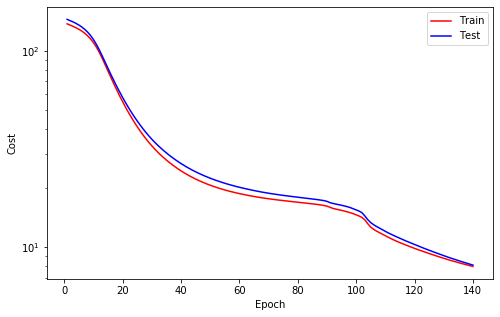



Epoch   141
Train_cost  = 7.9191 | Test_cost  = 8.0301 | 




Epoch   142
Train_cost  = 7.8519 | Test_cost  = 7.9480 | 




Epoch   143
Train_cost  = 7.7858 | Test_cost  = 7.8677 | 




Epoch   144
Train_cost  = 7.7208 | Test_cost  = 7.7893 | 




Epoch   145
Train_cost  = 7.6568 | Test_cost  = 7.7126 | 




Epoch   146
Train_cost  = 7.5939 | Test_cost  = 7.6374 | 




Epoch   147
Train_cost  = 7.5318 | Test_cost  = 7.5637 | 




Epoch   148
Train_cost  = 7.4702 | Test_cost  = 7.4912 | 




Epoch   149
Train_cost  = 7.4090 | Test_cost  = 7.4198 | 




Epoch   150
Train_cost  = 7.3481 | Test_cost  = 7.3495 | 




Epoch   151
Train_cost  = 7.2879 | Test_cost  = 7.2800 | 




Epoch   152
Train_cost  = 7.2282 | Test_cost  = 7.2117 | 




Epoch   153
Train_cost  = 7.1693 | Test_cost  = 7.1446 | 




Epoch   154
Train_cost  = 7.1114 | Test_cost  = 7.0789 | 




Epoch   155
Train_cost  = 7.0544 | Test_cost  = 7.0147 | 




Epoch   156
Train_cost  = 6.9981 | Test_cost  = 6.9522 | 




Epoch   157
Train_cost  = 6.9423 | Test_cost  = 6.8913 | 




Epoch   158
Train_cost  = 6.8874 | Test_cost  = 6.8315 | 




Epoch   159
Train_cost  = 6.8334 | Test_cost  = 6.7721 | 




Epoch   160
Train_cost  = 6.7802 | Test_cost  = 6.7132 | 


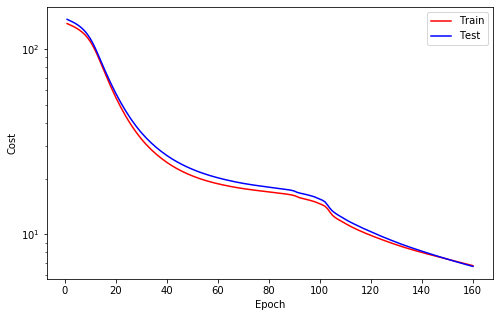



Epoch   161
Train_cost  = 6.7278 | Test_cost  = 6.6549 | 




Epoch   162
Train_cost  = 6.6760 | Test_cost  = 6.5974 | 




Epoch   163
Train_cost  = 6.6249 | Test_cost  = 6.5408 | 




Epoch   164
Train_cost  = 6.5744 | Test_cost  = 6.4850 | 




Epoch   165
Train_cost  = 6.5244 | Test_cost  = 6.4301 | 




Epoch   166
Train_cost  = 6.4750 | Test_cost  = 6.3759 | 




Epoch   167
Train_cost  = 6.4262 | Test_cost  = 6.3226 | 




Epoch   168
Train_cost  = 6.3780 | Test_cost  = 6.2702 | 




Epoch   169
Train_cost  = 6.3305 | Test_cost  = 6.2185 | 




Epoch   170
Train_cost  = 6.2837 | Test_cost  = 6.1678 | 




Epoch   171
Train_cost  = 6.2374 | Test_cost  = 6.1178 | 




Epoch   172
Train_cost  = 6.1918 | Test_cost  = 6.0685 | 




Epoch   173
Train_cost  = 6.1467 | Test_cost  = 6.0201 | 




Epoch   174
Train_cost  = 6.1021 | Test_cost  = 5.9723 | 




Epoch   175
Train_cost  = 6.0581 | Test_cost  = 5.9253 | 




Epoch   176
Train_cost  = 6.0145 | Test_cost  = 5.8790 | 




Epoch   177
Train_cost  = 5.9715 | Test_cost  = 5.8333 | 




Epoch   178
Train_cost  = 5.9289 | Test_cost  = 5.7883 | 




Epoch   179
Train_cost  = 5.8868 | Test_cost  = 5.7437 | 




Epoch   180
Train_cost  = 5.8451 | Test_cost  = 5.6996 | 


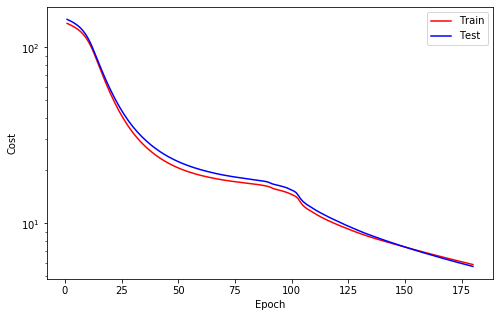



Epoch   181
Train_cost  = 5.8036 | Test_cost  = 5.6558 | 




Epoch   182
Train_cost  = 5.7625 | Test_cost  = 5.6125 | 




Epoch   183
Train_cost  = 5.7216 | Test_cost  = 5.5695 | 




Epoch   184
Train_cost  = 5.6810 | Test_cost  = 5.5268 | 




Epoch   185
Train_cost  = 5.6406 | Test_cost  = 5.4843 | 




Epoch   186
Train_cost  = 5.6003 | Test_cost  = 5.4420 | 




Epoch   187
Train_cost  = 5.5603 | Test_cost  = 5.3999 | 




Epoch   188
Train_cost  = 5.5205 | Test_cost  = 5.3579 | 




Epoch   189
Train_cost  = 5.4808 | Test_cost  = 5.3160 | 




Epoch   190
Train_cost  = 5.4413 | Test_cost  = 5.2743 | 




Epoch   191
Train_cost  = 5.4019 | Test_cost  = 5.2326 | 




Epoch   192
Train_cost  = 5.3626 | Test_cost  = 5.1910 | 




Epoch   193
Train_cost  = 5.3234 | Test_cost  = 5.1495 | 




Epoch   194
Train_cost  = 5.2843 | Test_cost  = 5.1081 | 




Epoch   195
Train_cost  = 5.2452 | Test_cost  = 5.0667 | 




Epoch   196
Train_cost  = 5.2061 | Test_cost  = 5.0253 | 




Epoch   197
Train_cost  = 5.1670 | Test_cost  = 4.9839 | 




Epoch   198
Train_cost  = 5.1280 | Test_cost  = 4.9425 | 




Epoch   199
Train_cost  = 5.0889 | Test_cost  = 4.9012 | 




Epoch   200
Train_cost  = 5.0500 | Test_cost  = 4.8600 | 


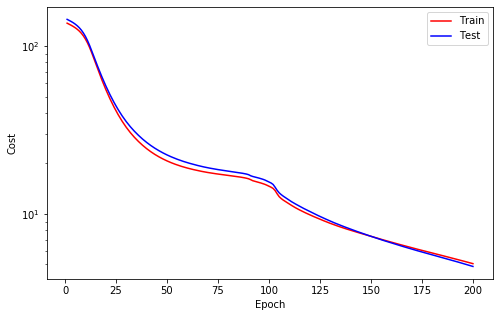



Epoch   201
Train_cost  = 5.0111 | Test_cost  = 4.8189 | 




Epoch   202
Train_cost  = 4.9722 | Test_cost  = 4.7780 | 




Epoch   203
Train_cost  = 4.9335 | Test_cost  = 4.7372 | 




Epoch   204
Train_cost  = 4.8948 | Test_cost  = 4.6965 | 




Epoch   205
Train_cost  = 4.8562 | Test_cost  = 4.6561 | 




Epoch   206
Train_cost  = 4.8177 | Test_cost  = 4.6158 | 




Epoch   207
Train_cost  = 4.7792 | Test_cost  = 4.5758 | 




Epoch   208
Train_cost  = 4.7408 | Test_cost  = 4.5360 | 




Epoch   209
Train_cost  = 4.7025 | Test_cost  = 4.4963 | 




Epoch   210
Train_cost  = 4.6642 | Test_cost  = 4.4569 | 




Epoch   211
Train_cost  = 4.6261 | Test_cost  = 4.4176 | 




Epoch   212
Train_cost  = 4.5882 | Test_cost  = 4.3785 | 




Epoch   213
Train_cost  = 4.5504 | Test_cost  = 4.3395 | 




Epoch   214
Train_cost  = 4.5128 | Test_cost  = 4.3007 | 




Epoch   215
Train_cost  = 4.4755 | Test_cost  = 4.2620 | 




Epoch   216
Train_cost  = 4.4383 | Test_cost  = 4.2234 | 




Epoch   217
Train_cost  = 4.4014 | Test_cost  = 4.1850 | 




Epoch   218
Train_cost  = 4.3646 | Test_cost  = 4.1468 | 




Epoch   219
Train_cost  = 4.3281 | Test_cost  = 4.1087 | 




Epoch   220
Train_cost  = 4.2918 | Test_cost  = 4.0709 | 


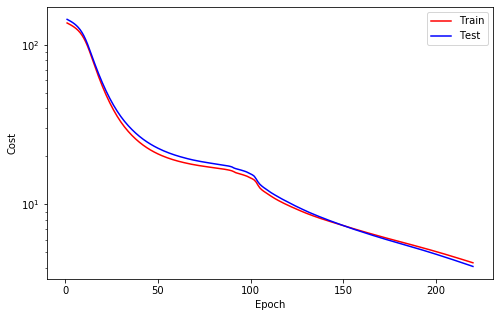



Epoch   221
Train_cost  = 4.2557 | Test_cost  = 4.0332 | 




Epoch   222
Train_cost  = 4.2199 | Test_cost  = 3.9958 | 




Epoch   223
Train_cost  = 4.1843 | Test_cost  = 3.9586 | 




Epoch   224
Train_cost  = 4.1490 | Test_cost  = 3.9216 | 




Epoch   225
Train_cost  = 4.1140 | Test_cost  = 3.8848 | 




Epoch   226
Train_cost  = 4.0794 | Test_cost  = 3.8483 | 




Epoch   227
Train_cost  = 4.0451 | Test_cost  = 3.8120 | 




Epoch   228
Train_cost  = 4.0112 | Test_cost  = 3.7759 | 




Epoch   229
Train_cost  = 3.9776 | Test_cost  = 3.7400 | 




Epoch   230
Train_cost  = 3.9445 | Test_cost  = 3.7043 | 




Epoch   231
Train_cost  = 3.9117 | Test_cost  = 3.6689 | 




Epoch   232
Train_cost  = 3.8794 | Test_cost  = 3.6338 | 




Epoch   233
Train_cost  = 3.8475 | Test_cost  = 3.5989 | 




Epoch   234
Train_cost  = 3.8160 | Test_cost  = 3.5644 | 




Epoch   235
Train_cost  = 3.7850 | Test_cost  = 3.5302 | 




Epoch   236
Train_cost  = 3.7544 | Test_cost  = 3.4964 | 




Epoch   237
Train_cost  = 3.7242 | Test_cost  = 3.4630 | 




Epoch   238
Train_cost  = 3.6944 | Test_cost  = 3.4298 | 




Epoch   239
Train_cost  = 3.6650 | Test_cost  = 3.3970 | 




Epoch   240
Train_cost  = 3.6359 | Test_cost  = 3.3646 | 


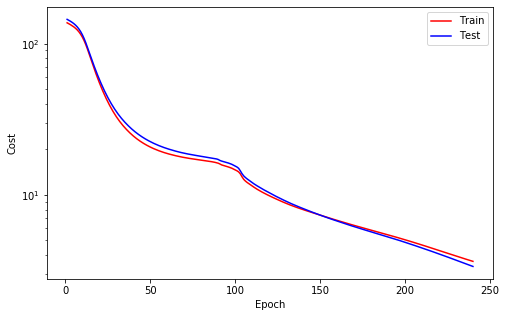



Epoch   241
Train_cost  = 3.6071 | Test_cost  = 3.3324 | 




Epoch   242
Train_cost  = 3.5786 | Test_cost  = 3.3005 | 




Epoch   243
Train_cost  = 3.5504 | Test_cost  = 3.2688 | 




Epoch   244
Train_cost  = 3.5224 | Test_cost  = 3.2374 | 




Epoch   245
Train_cost  = 3.4947 | Test_cost  = 3.2063 | 




Epoch   246
Train_cost  = 3.4672 | Test_cost  = 3.1754 | 




Epoch   247
Train_cost  = 3.4399 | Test_cost  = 3.1448 | 




Epoch   248
Train_cost  = 3.4129 | Test_cost  = 3.1145 | 




Epoch   249
Train_cost  = 3.3861 | Test_cost  = 3.0844 | 




Epoch   250
Train_cost  = 3.3595 | Test_cost  = 3.0546 | 




Epoch   251
Train_cost  = 3.3330 | Test_cost  = 3.0250 | 




Epoch   252
Train_cost  = 3.3068 | Test_cost  = 2.9957 | 




Epoch   253
Train_cost  = 3.2808 | Test_cost  = 2.9666 | 




Epoch   254
Train_cost  = 3.2549 | Test_cost  = 2.9377 | 




Epoch   255
Train_cost  = 3.2293 | Test_cost  = 2.9091 | 




Epoch   256
Train_cost  = 3.2038 | Test_cost  = 2.8808 | 




Epoch   257
Train_cost  = 3.1786 | Test_cost  = 2.8527 | 




Epoch   258
Train_cost  = 3.1537 | Test_cost  = 2.8249 | 




Epoch   259
Train_cost  = 3.1289 | Test_cost  = 2.7975 | 




Epoch   260
Train_cost  = 3.1043 | Test_cost  = 2.7703 | 


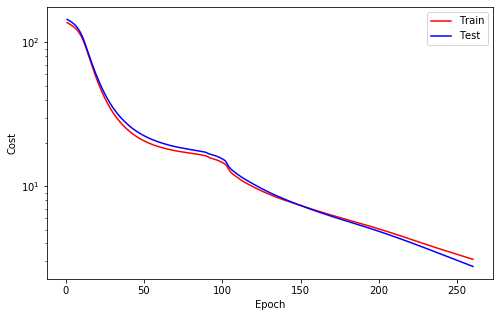



Epoch   261
Train_cost  = 3.0799 | Test_cost  = 2.7435 | 




Epoch   262
Train_cost  = 3.0556 | Test_cost  = 2.7169 | 




Epoch   263
Train_cost  = 3.0315 | Test_cost  = 2.6905 | 




Epoch   264
Train_cost  = 3.0075 | Test_cost  = 2.6643 | 




Epoch   265
Train_cost  = 2.9836 | Test_cost  = 2.6384 | 




Epoch   266
Train_cost  = 2.9598 | Test_cost  = 2.6127 | 




Epoch   267
Train_cost  = 2.9361 | Test_cost  = 2.5871 | 




Epoch   268
Train_cost  = 2.9125 | Test_cost  = 2.5618 | 




Epoch   269
Train_cost  = 2.8890 | Test_cost  = 2.5366 | 




Epoch   270
Train_cost  = 2.8655 | Test_cost  = 2.5116 | 




Epoch   271
Train_cost  = 2.8422 | Test_cost  = 2.4867 | 




Epoch   272
Train_cost  = 2.8189 | Test_cost  = 2.4621 | 




Epoch   273
Train_cost  = 2.7956 | Test_cost  = 2.4375 | 




Epoch   274
Train_cost  = 2.7724 | Test_cost  = 2.4130 | 




Epoch   275
Train_cost  = 2.7492 | Test_cost  = 2.3887 | 




Epoch   276
Train_cost  = 2.7260 | Test_cost  = 2.3644 | 




Epoch   277
Train_cost  = 2.7028 | Test_cost  = 2.3401 | 




Epoch   278
Train_cost  = 2.6796 | Test_cost  = 2.3159 | 




Epoch   279
Train_cost  = 2.6564 | Test_cost  = 2.2919 | 




Epoch   280
Train_cost  = 2.6333 | Test_cost  = 2.2680 | 


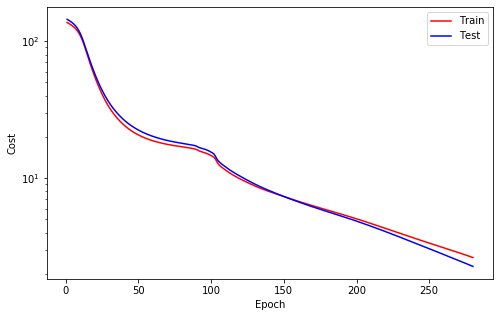



Epoch   281
Train_cost  = 2.6104 | Test_cost  = 2.2443 | 




Epoch   282
Train_cost  = 2.5877 | Test_cost  = 2.2209 | 




Epoch   283
Train_cost  = 2.5651 | Test_cost  = 2.1977 | 




Epoch   284
Train_cost  = 2.5427 | Test_cost  = 2.1747 | 




Epoch   285
Train_cost  = 2.5203 | Test_cost  = 2.1518 | 




Epoch   286
Train_cost  = 2.4980 | Test_cost  = 2.1292 | 




Epoch   287
Train_cost  = 2.4759 | Test_cost  = 2.1066 | 




Epoch   288
Train_cost  = 2.4538 | Test_cost  = 2.0843 | 




Epoch   289
Train_cost  = 2.4318 | Test_cost  = 2.0621 | 




Epoch   290
Train_cost  = 2.4098 | Test_cost  = 2.0400 | 




Epoch   291
Train_cost  = 2.3880 | Test_cost  = 2.0181 | 




Epoch   292
Train_cost  = 2.3662 | Test_cost  = 1.9964 | 




Epoch   293
Train_cost  = 2.3445 | Test_cost  = 1.9748 | 




Epoch   294
Train_cost  = 2.3229 | Test_cost  = 1.9534 | 




Epoch   295
Train_cost  = 2.3015 | Test_cost  = 1.9322 | 




Epoch   296
Train_cost  = 2.2801 | Test_cost  = 1.9111 | 




Epoch   297
Train_cost  = 2.2588 | Test_cost  = 1.8902 | 




Epoch   298
Train_cost  = 2.2377 | Test_cost  = 1.8695 | 




Epoch   299
Train_cost  = 2.2167 | Test_cost  = 1.8490 | 




Epoch   300
Train_cost  = 2.1959 | Test_cost  = 1.8287 | 


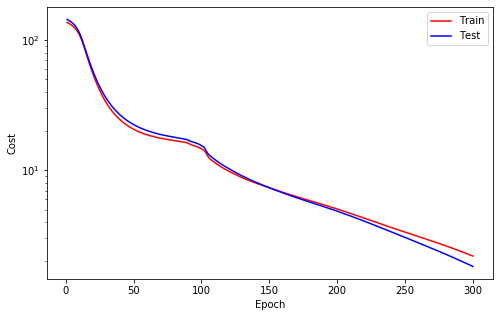



Epoch   301
Train_cost  = 2.1752 | Test_cost  = 1.8085 | 




Epoch   302
Train_cost  = 2.1546 | Test_cost  = 1.7885 | 




Epoch   303
Train_cost  = 2.1342 | Test_cost  = 1.7688 | 




Epoch   304
Train_cost  = 2.1139 | Test_cost  = 1.7492 | 




Epoch   305
Train_cost  = 2.0938 | Test_cost  = 1.7298 | 




Epoch   306
Train_cost  = 2.0738 | Test_cost  = 1.7106 | 




Epoch   307
Train_cost  = 2.0540 | Test_cost  = 1.6916 | 




Epoch   308
Train_cost  = 2.0344 | Test_cost  = 1.6729 | 




Epoch   309
Train_cost  = 2.0149 | Test_cost  = 1.6543 | 




Epoch   310
Train_cost  = 1.9956 | Test_cost  = 1.6359 | 




Epoch   311
Train_cost  = 1.9765 | Test_cost  = 1.6177 | 




Epoch   312
Train_cost  = 1.9575 | Test_cost  = 1.5997 | 




Epoch   313
Train_cost  = 1.9387 | Test_cost  = 1.5819 | 




Epoch   314
Train_cost  = 1.9201 | Test_cost  = 1.5643 | 




Epoch   315
Train_cost  = 1.9017 | Test_cost  = 1.5469 | 




Epoch   316
Train_cost  = 1.8834 | Test_cost  = 1.5297 | 




Epoch   317
Train_cost  = 1.8653 | Test_cost  = 1.5127 | 




Epoch   318
Train_cost  = 1.8474 | Test_cost  = 1.4958 | 




Epoch   319
Train_cost  = 1.8296 | Test_cost  = 1.4791 | 




Epoch   320
Train_cost  = 1.8121 | Test_cost  = 1.4627 | 


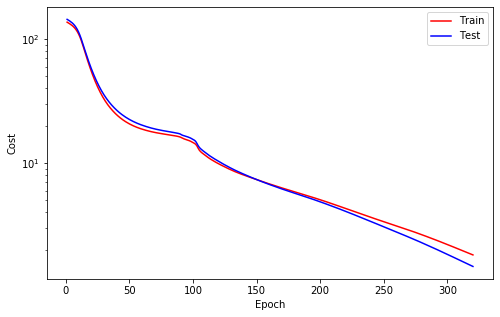



Epoch   321
Train_cost  = 1.7947 | Test_cost  = 1.4464 | 




Epoch   322
Train_cost  = 1.7775 | Test_cost  = 1.4303 | 




Epoch   323
Train_cost  = 1.7605 | Test_cost  = 1.4143 | 




Epoch   324
Train_cost  = 1.7437 | Test_cost  = 1.3986 | 




Epoch   325
Train_cost  = 1.7270 | Test_cost  = 1.3831 | 




Epoch   326
Train_cost  = 1.7106 | Test_cost  = 1.3677 | 




Epoch   327
Train_cost  = 1.6943 | Test_cost  = 1.3525 | 




Epoch   328
Train_cost  = 1.6783 | Test_cost  = 1.3375 | 




Epoch   329
Train_cost  = 1.6624 | Test_cost  = 1.3227 | 




Epoch   330
Train_cost  = 1.6468 | Test_cost  = 1.3081 | 




Epoch   331
Train_cost  = 1.6313 | Test_cost  = 1.2937 | 




Epoch   332
Train_cost  = 1.6161 | Test_cost  = 1.2794 | 




Epoch   333
Train_cost  = 1.6010 | Test_cost  = 1.2654 | 




Epoch   334
Train_cost  = 1.5862 | Test_cost  = 1.2515 | 




Epoch   335
Train_cost  = 1.5715 | Test_cost  = 1.2378 | 




Epoch   336
Train_cost  = 1.5571 | Test_cost  = 1.2243 | 




Epoch   337
Train_cost  = 1.5428 | Test_cost  = 1.2110 | 




Epoch   338
Train_cost  = 1.5288 | Test_cost  = 1.1978 | 




Epoch   339
Train_cost  = 1.5149 | Test_cost  = 1.1848 | 




Epoch   340
Train_cost  = 1.5013 | Test_cost  = 1.1720 | 


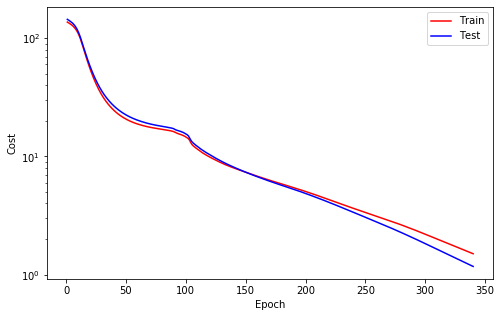



Epoch   341
Train_cost  = 1.4878 | Test_cost  = 1.1594 | 




Epoch   342
Train_cost  = 1.4746 | Test_cost  = 1.1469 | 




Epoch   343
Train_cost  = 1.4616 | Test_cost  = 1.1346 | 




Epoch   344
Train_cost  = 1.4488 | Test_cost  = 1.1225 | 




Epoch   345
Train_cost  = 1.4362 | Test_cost  = 1.1106 | 




Epoch   346
Train_cost  = 1.4239 | Test_cost  = 1.0989 | 




Epoch   347
Train_cost  = 1.4117 | Test_cost  = 1.0874 | 




Epoch   348
Train_cost  = 1.3998 | Test_cost  = 1.0761 | 




Epoch   349
Train_cost  = 1.3882 | Test_cost  = 1.0650 | 




Epoch   350
Train_cost  = 1.3767 | Test_cost  = 1.0541 | 




Epoch   351
Train_cost  = 1.3655 | Test_cost  = 1.0434 | 




Epoch   352
Train_cost  = 1.3545 | Test_cost  = 1.0328 | 




Epoch   353
Train_cost  = 1.3437 | Test_cost  = 1.0225 | 




Epoch   354
Train_cost  = 1.3331 | Test_cost  = 1.0123 | 




Epoch   355
Train_cost  = 1.3227 | Test_cost  = 1.0024 | 




Epoch   356
Train_cost  = 1.3125 | Test_cost  = 0.9926 | 




Epoch   357
Train_cost  = 1.3026 | Test_cost  = 0.9830 | 




Epoch   358
Train_cost  = 1.2928 | Test_cost  = 0.9735 | 




Epoch   359
Train_cost  = 1.2832 | Test_cost  = 0.9643 | 




Epoch   360
Train_cost  = 1.2738 | Test_cost  = 0.9552 | 


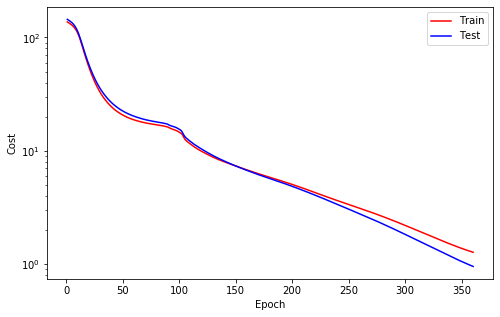



Epoch   361
Train_cost  = 1.2646 | Test_cost  = 0.9463 | 




Epoch   362
Train_cost  = 1.2556 | Test_cost  = 0.9375 | 




Epoch   363
Train_cost  = 1.2468 | Test_cost  = 0.9289 | 




Epoch   364
Train_cost  = 1.2381 | Test_cost  = 0.9205 | 




Epoch   365
Train_cost  = 1.2296 | Test_cost  = 0.9122 | 




Epoch   366
Train_cost  = 1.2213 | Test_cost  = 0.9041 | 




Epoch   367
Train_cost  = 1.2131 | Test_cost  = 0.8961 | 




Epoch   368
Train_cost  = 1.2051 | Test_cost  = 0.8882 | 




Epoch   369
Train_cost  = 1.1972 | Test_cost  = 0.8805 | 




Epoch   370
Train_cost  = 1.1895 | Test_cost  = 0.8730 | 




Epoch   371
Train_cost  = 1.1819 | Test_cost  = 0.8656 | 




Epoch   372
Train_cost  = 1.1745 | Test_cost  = 0.8583 | 




Epoch   373
Train_cost  = 1.1672 | Test_cost  = 0.8511 | 




Epoch   374
Train_cost  = 1.1601 | Test_cost  = 0.8441 | 




Epoch   375
Train_cost  = 1.1530 | Test_cost  = 0.8372 | 




Epoch   376
Train_cost  = 1.1461 | Test_cost  = 0.8304 | 




Epoch   377
Train_cost  = 1.1393 | Test_cost  = 0.8237 | 




Epoch   378
Train_cost  = 1.1326 | Test_cost  = 0.8171 | 




Epoch   379
Train_cost  = 1.1261 | Test_cost  = 0.8107 | 




Epoch   380
Train_cost  = 1.1196 | Test_cost  = 0.8043 | 


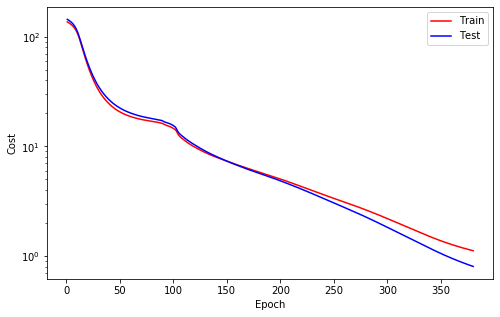



Epoch   381
Train_cost  = 1.1133 | Test_cost  = 0.7981 | 




Epoch   382
Train_cost  = 1.1070 | Test_cost  = 0.7920 | 




Epoch   383
Train_cost  = 1.1009 | Test_cost  = 0.7859 | 




Epoch   384
Train_cost  = 1.0948 | Test_cost  = 0.7800 | 




Epoch   385
Train_cost  = 1.0889 | Test_cost  = 0.7741 | 




Epoch   386
Train_cost  = 1.0830 | Test_cost  = 0.7684 | 




Epoch   387
Train_cost  = 1.0772 | Test_cost  = 0.7627 | 




Epoch   388
Train_cost  = 1.0715 | Test_cost  = 0.7572 | 




Epoch   389
Train_cost  = 1.0659 | Test_cost  = 0.7517 | 




Epoch   390
Train_cost  = 1.0604 | Test_cost  = 0.7463 | 




Epoch   391
Train_cost  = 1.0549 | Test_cost  = 0.7410 | 




Epoch   392
Train_cost  = 1.0496 | Test_cost  = 0.7357 | 




Epoch   393
Train_cost  = 1.0443 | Test_cost  = 0.7306 | 




Epoch   394
Train_cost  = 1.0391 | Test_cost  = 0.7255 | 




Epoch   395
Train_cost  = 1.0339 | Test_cost  = 0.7205 | 




Epoch   396
Train_cost  = 1.0288 | Test_cost  = 0.7156 | 




Epoch   397
Train_cost  = 1.0238 | Test_cost  = 0.7107 | 




Epoch   398
Train_cost  = 1.0189 | Test_cost  = 0.7059 | 




Epoch   399
Train_cost  = 1.0140 | Test_cost  = 0.7012 | 




Epoch   400
Train_cost  = 1.0091 | Test_cost  = 0.6966 | 


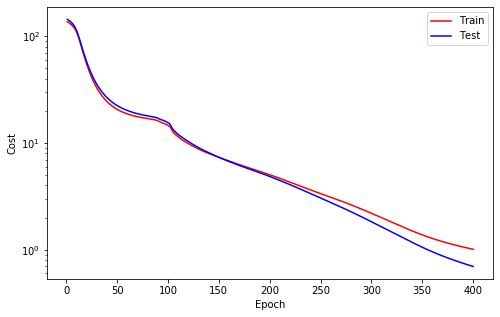



Epoch   401
Train_cost  = 1.0044 | Test_cost  = 0.6920 | 




Epoch   402
Train_cost  = 0.9997 | Test_cost  = 0.6875 | 




Epoch   403
Train_cost  = 0.9950 | Test_cost  = 0.6830 | 




Epoch   404
Train_cost  = 0.9905 | Test_cost  = 0.6786 | 




Epoch   405
Train_cost  = 0.9859 | Test_cost  = 0.6743 | 




Epoch   406
Train_cost  = 0.9815 | Test_cost  = 0.6700 | 




Epoch   407
Train_cost  = 0.9770 | Test_cost  = 0.6658 | 




Epoch   408
Train_cost  = 0.9727 | Test_cost  = 0.6617 | 




Epoch   409
Train_cost  = 0.9684 | Test_cost  = 0.6576 | 




Epoch   410
Train_cost  = 0.9641 | Test_cost  = 0.6535 | 




Epoch   411
Train_cost  = 0.9599 | Test_cost  = 0.6496 | 




Epoch   412
Train_cost  = 0.9557 | Test_cost  = 0.6456 | 




Epoch   413
Train_cost  = 0.9516 | Test_cost  = 0.6417 | 




Epoch   414
Train_cost  = 0.9475 | Test_cost  = 0.6379 | 




Epoch   415
Train_cost  = 0.9435 | Test_cost  = 0.6341 | 




Epoch   416
Train_cost  = 0.9395 | Test_cost  = 0.6304 | 




Epoch   417
Train_cost  = 0.9355 | Test_cost  = 0.6267 | 




Epoch   418
Train_cost  = 0.9316 | Test_cost  = 0.6231 | 




Epoch   419
Train_cost  = 0.9278 | Test_cost  = 0.6195 | 




Epoch   420
Train_cost  = 0.9239 | Test_cost  = 0.6160 | 


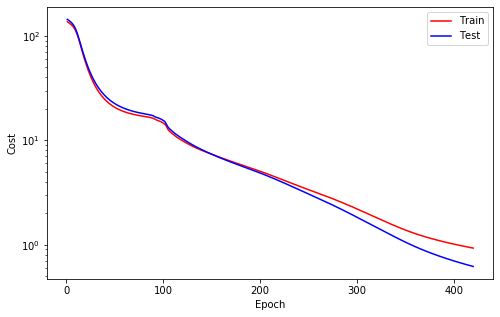



Epoch   421
Train_cost  = 0.9202 | Test_cost  = 0.6125 | 




Epoch   422
Train_cost  = 0.9164 | Test_cost  = 0.6090 | 




Epoch   423
Train_cost  = 0.9127 | Test_cost  = 0.6056 | 




Epoch   424
Train_cost  = 0.9091 | Test_cost  = 0.6023 | 




Epoch   425
Train_cost  = 0.9054 | Test_cost  = 0.5989 | 




Epoch   426
Train_cost  = 0.9019 | Test_cost  = 0.5956 | 




Epoch   427
Train_cost  = 0.8983 | Test_cost  = 0.5924 | 




Epoch   428
Train_cost  = 0.8948 | Test_cost  = 0.5892 | 




Epoch   429
Train_cost  = 0.8913 | Test_cost  = 0.5860 | 




Epoch   430
Train_cost  = 0.8879 | Test_cost  = 0.5829 | 




Epoch   431
Train_cost  = 0.8844 | Test_cost  = 0.5798 | 




Epoch   432
Train_cost  = 0.8811 | Test_cost  = 0.5768 | 




Epoch   433
Train_cost  = 0.8777 | Test_cost  = 0.5738 | 




Epoch   434
Train_cost  = 0.8744 | Test_cost  = 0.5708 | 




Epoch   435
Train_cost  = 0.8711 | Test_cost  = 0.5678 | 




Epoch   436
Train_cost  = 0.8679 | Test_cost  = 0.5649 | 




Epoch   437
Train_cost  = 0.8646 | Test_cost  = 0.5620 | 




Epoch   438
Train_cost  = 0.8614 | Test_cost  = 0.5592 | 




Epoch   439
Train_cost  = 0.8583 | Test_cost  = 0.5564 | 




Epoch   440
Train_cost  = 0.8551 | Test_cost  = 0.5536 | 


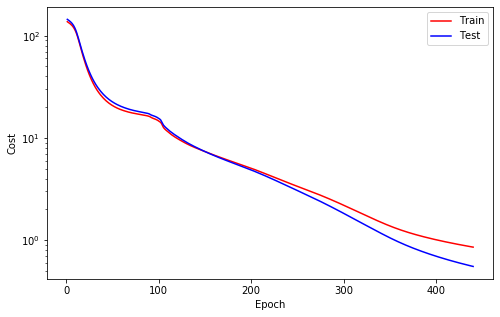



Epoch   441
Train_cost  = 0.8520 | Test_cost  = 0.5509 | 




Epoch   442
Train_cost  = 0.8490 | Test_cost  = 0.5481 | 




Epoch   443
Train_cost  = 0.8459 | Test_cost  = 0.5454 | 




Epoch   444
Train_cost  = 0.8429 | Test_cost  = 0.5428 | 




Epoch   445
Train_cost  = 0.8399 | Test_cost  = 0.5402 | 




Epoch   446
Train_cost  = 0.8369 | Test_cost  = 0.5376 | 




Epoch   447
Train_cost  = 0.8340 | Test_cost  = 0.5350 | 




Epoch   448
Train_cost  = 0.8310 | Test_cost  = 0.5324 | 




Epoch   449
Train_cost  = 0.8281 | Test_cost  = 0.5299 | 




Epoch   450
Train_cost  = 0.8253 | Test_cost  = 0.5274 | 




Epoch   451
Train_cost  = 0.8224 | Test_cost  = 0.5250 | 




Epoch   452
Train_cost  = 0.8196 | Test_cost  = 0.5225 | 




Epoch   453
Train_cost  = 0.8168 | Test_cost  = 0.5201 | 




Epoch   454
Train_cost  = 0.8140 | Test_cost  = 0.5177 | 




Epoch   455
Train_cost  = 0.8113 | Test_cost  = 0.5153 | 




Epoch   456
Train_cost  = 0.8085 | Test_cost  = 0.5130 | 




Epoch   457
Train_cost  = 0.8058 | Test_cost  = 0.5107 | 




Epoch   458
Train_cost  = 0.8032 | Test_cost  = 0.5084 | 




Epoch   459
Train_cost  = 0.8005 | Test_cost  = 0.5061 | 




Epoch   460
Train_cost  = 0.7978 | Test_cost  = 0.5039 | 


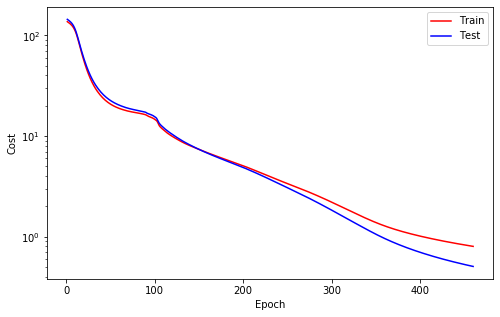



Epoch   461
Train_cost  = 0.7952 | Test_cost  = 0.5016 | 




Epoch   462
Train_cost  = 0.7926 | Test_cost  = 0.4994 | 




Epoch   463
Train_cost  = 0.7900 | Test_cost  = 0.4972 | 




Epoch   464
Train_cost  = 0.7875 | Test_cost  = 0.4951 | 




Epoch   465
Train_cost  = 0.7849 | Test_cost  = 0.4929 | 




Epoch   466
Train_cost  = 0.7824 | Test_cost  = 0.4908 | 




Epoch   467
Train_cost  = 0.7799 | Test_cost  = 0.4887 | 




Epoch   468
Train_cost  = 0.7774 | Test_cost  = 0.4866 | 




Epoch   469
Train_cost  = 0.7750 | Test_cost  = 0.4846 | 




Epoch   470
Train_cost  = 0.7725 | Test_cost  = 0.4825 | 




Epoch   471
Train_cost  = 0.7701 | Test_cost  = 0.4805 | 




Epoch   472
Train_cost  = 0.7677 | Test_cost  = 0.4785 | 




Epoch   473
Train_cost  = 0.7653 | Test_cost  = 0.4765 | 




Epoch   474
Train_cost  = 0.7629 | Test_cost  = 0.4745 | 




Epoch   475
Train_cost  = 0.7605 | Test_cost  = 0.4726 | 




Epoch   476
Train_cost  = 0.7582 | Test_cost  = 0.4706 | 




Epoch   477
Train_cost  = 0.7559 | Test_cost  = 0.4687 | 




Epoch   478
Train_cost  = 0.7536 | Test_cost  = 0.4668 | 




Epoch   479
Train_cost  = 0.7513 | Test_cost  = 0.4649 | 




Epoch   480
Train_cost  = 0.7490 | Test_cost  = 0.4631 | 


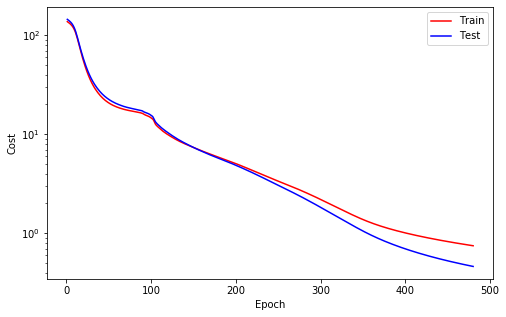



Epoch   481
Train_cost  = 0.7467 | Test_cost  = 0.4612 | 




Epoch   482
Train_cost  = 0.7445 | Test_cost  = 0.4594 | 




Epoch   483
Train_cost  = 0.7423 | Test_cost  = 0.4576 | 




Epoch   484
Train_cost  = 0.7400 | Test_cost  = 0.4558 | 




Epoch   485
Train_cost  = 0.7378 | Test_cost  = 0.4540 | 




Epoch   486
Train_cost  = 0.7356 | Test_cost  = 0.4522 | 




Epoch   487
Train_cost  = 0.7335 | Test_cost  = 0.4504 | 




Epoch   488
Train_cost  = 0.7313 | Test_cost  = 0.4487 | 




Epoch   489
Train_cost  = 0.7292 | Test_cost  = 0.4470 | 




Epoch   490
Train_cost  = 0.7271 | Test_cost  = 0.4453 | 




Epoch   491
Train_cost  = 0.7249 | Test_cost  = 0.4436 | 




Epoch   492
Train_cost  = 0.7228 | Test_cost  = 0.4419 | 




Epoch   493
Train_cost  = 0.7208 | Test_cost  = 0.4402 | 




Epoch   494
Train_cost  = 0.7187 | Test_cost  = 0.4386 | 




Epoch   495
Train_cost  = 0.7166 | Test_cost  = 0.4369 | 




Epoch   496
Train_cost  = 0.7146 | Test_cost  = 0.4353 | 




Epoch   497
Train_cost  = 0.7125 | Test_cost  = 0.4337 | 




Epoch   498
Train_cost  = 0.7105 | Test_cost  = 0.4321 | 




Epoch   499
Train_cost  = 0.7085 | Test_cost  = 0.4305 | 




Epoch   500
Train_cost  = 0.7065 | Test_cost  = 0.4290 | 


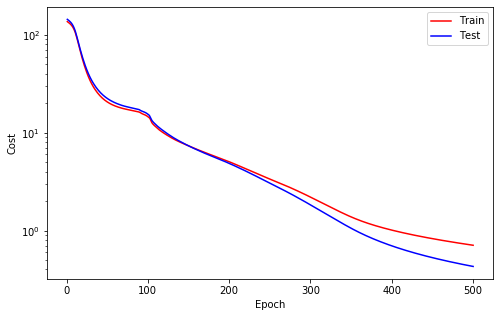



Epoch   501
Train_cost  = 0.7045 | Test_cost  = 0.4274 | 




Epoch   502
Train_cost  = 0.7026 | Test_cost  = 0.4259 | 




Epoch   503
Train_cost  = 0.7006 | Test_cost  = 0.4244 | 




Epoch   504
Train_cost  = 0.6987 | Test_cost  = 0.4229 | 




Epoch   505
Train_cost  = 0.6967 | Test_cost  = 0.4214 | 




Epoch   506
Train_cost  = 0.6948 | Test_cost  = 0.4199 | 




Epoch   507
Train_cost  = 0.6929 | Test_cost  = 0.4185 | 




Epoch   508
Train_cost  = 0.6910 | Test_cost  = 0.4170 | 




Epoch   509
Train_cost  = 0.6892 | Test_cost  = 0.4156 | 




Epoch   510
Train_cost  = 0.6873 | Test_cost  = 0.4142 | 




Epoch   511
Train_cost  = 0.6854 | Test_cost  = 0.4128 | 




Epoch   512
Train_cost  = 0.6836 | Test_cost  = 0.4114 | 




Epoch   513
Train_cost  = 0.6818 | Test_cost  = 0.4100 | 




Epoch   514
Train_cost  = 0.6799 | Test_cost  = 0.4086 | 




Epoch   515
Train_cost  = 0.6781 | Test_cost  = 0.4073 | 




Epoch   516
Train_cost  = 0.6763 | Test_cost  = 0.4060 | 




Epoch   517
Train_cost  = 0.6745 | Test_cost  = 0.4047 | 




Epoch   518
Train_cost  = 0.6728 | Test_cost  = 0.4034 | 




Epoch   519
Train_cost  = 0.6710 | Test_cost  = 0.4021 | 




Epoch   520
Train_cost  = 0.6692 | Test_cost  = 0.4008 | 


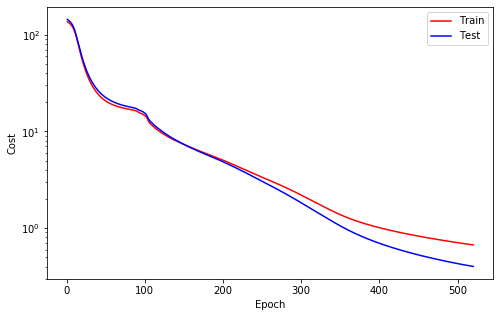



Epoch   521
Train_cost  = 0.6675 | Test_cost  = 0.3995 | 




Epoch   522
Train_cost  = 0.6658 | Test_cost  = 0.3983 | 




Epoch   523
Train_cost  = 0.6641 | Test_cost  = 0.3971 | 




Epoch   524
Train_cost  = 0.6623 | Test_cost  = 0.3959 | 




Epoch   525
Train_cost  = 0.6607 | Test_cost  = 0.3947 | 




Epoch   526
Train_cost  = 0.6590 | Test_cost  = 0.3935 | 




Epoch   527
Train_cost  = 0.6573 | Test_cost  = 0.3923 | 




Epoch   528
Train_cost  = 0.6556 | Test_cost  = 0.3911 | 




Epoch   529
Train_cost  = 0.6540 | Test_cost  = 0.3900 | 




Epoch   530
Train_cost  = 0.6523 | Test_cost  = 0.3889 | 




Epoch   531
Train_cost  = 0.6507 | Test_cost  = 0.3878 | 




Epoch   532
Train_cost  = 0.6491 | Test_cost  = 0.3867 | 




Epoch   533
Train_cost  = 0.6475 | Test_cost  = 0.3856 | 




Epoch   534
Train_cost  = 0.6459 | Test_cost  = 0.3845 | 




Epoch   535
Train_cost  = 0.6443 | Test_cost  = 0.3834 | 




Epoch   536
Train_cost  = 0.6427 | Test_cost  = 0.3824 | 




Epoch   537
Train_cost  = 0.6411 | Test_cost  = 0.3813 | 




Epoch   538
Train_cost  = 0.6395 | Test_cost  = 0.3803 | 




Epoch   539
Train_cost  = 0.6380 | Test_cost  = 0.3793 | 




Epoch   540
Train_cost  = 0.6364 | Test_cost  = 0.3782 | 


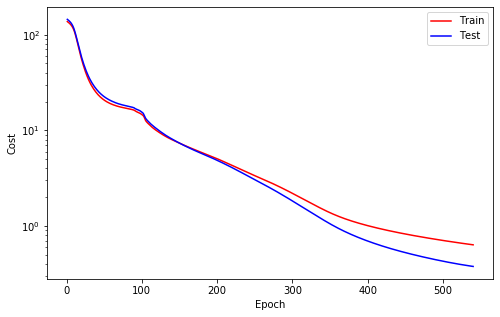



Epoch   541
Train_cost  = 0.6349 | Test_cost  = 0.3772 | 




Epoch   542
Train_cost  = 0.6334 | Test_cost  = 0.3763 | 




Epoch   543
Train_cost  = 0.6319 | Test_cost  = 0.3753 | 




Epoch   544
Train_cost  = 0.6304 | Test_cost  = 0.3743 | 




Epoch   545
Train_cost  = 0.6289 | Test_cost  = 0.3733 | 




Epoch   546
Train_cost  = 0.6274 | Test_cost  = 0.3724 | 




Epoch   547
Train_cost  = 0.6259 | Test_cost  = 0.3715 | 




Epoch   548
Train_cost  = 0.6244 | Test_cost  = 0.3705 | 




Epoch   549
Train_cost  = 0.6229 | Test_cost  = 0.3696 | 




Epoch   550
Train_cost  = 0.6215 | Test_cost  = 0.3687 | 




Epoch   551
Train_cost  = 0.6200 | Test_cost  = 0.3678 | 




Epoch   552
Train_cost  = 0.6186 | Test_cost  = 0.3669 | 




Epoch   553
Train_cost  = 0.6172 | Test_cost  = 0.3660 | 




Epoch   554
Train_cost  = 0.6158 | Test_cost  = 0.3651 | 




Epoch   555
Train_cost  = 0.6143 | Test_cost  = 0.3643 | 




Epoch   556
Train_cost  = 0.6129 | Test_cost  = 0.3634 | 




Epoch   557
Train_cost  = 0.6115 | Test_cost  = 0.3626 | 




Epoch   558
Train_cost  = 0.6101 | Test_cost  = 0.3617 | 




Epoch   559
Train_cost  = 0.6088 | Test_cost  = 0.3609 | 




Epoch   560
Train_cost  = 0.6074 | Test_cost  = 0.3601 | 


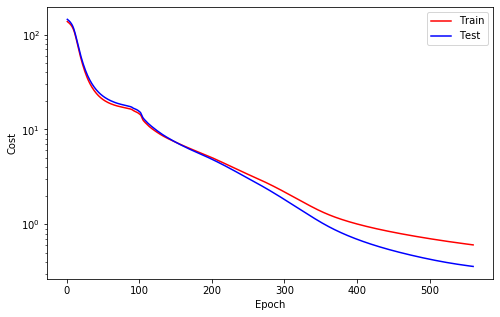



Epoch   561
Train_cost  = 0.6060 | Test_cost  = 0.3593 | 




Epoch   562
Train_cost  = 0.6047 | Test_cost  = 0.3584 | 




Epoch   563
Train_cost  = 0.6033 | Test_cost  = 0.3576 | 




Epoch   564
Train_cost  = 0.6020 | Test_cost  = 0.3569 | 




Epoch   565
Train_cost  = 0.6006 | Test_cost  = 0.3561 | 




Epoch   566
Train_cost  = 0.5993 | Test_cost  = 0.3553 | 




Epoch   567
Train_cost  = 0.5980 | Test_cost  = 0.3545 | 




Epoch   568
Train_cost  = 0.5966 | Test_cost  = 0.3538 | 




Epoch   569
Train_cost  = 0.5953 | Test_cost  = 0.3530 | 




Epoch   570
Train_cost  = 0.5940 | Test_cost  = 0.3523 | 




Epoch   571
Train_cost  = 0.5927 | Test_cost  = 0.3515 | 




Epoch   572
Train_cost  = 0.5914 | Test_cost  = 0.3508 | 




Epoch   573
Train_cost  = 0.5901 | Test_cost  = 0.3501 | 




Epoch   574
Train_cost  = 0.5889 | Test_cost  = 0.3493 | 




Epoch   575
Train_cost  = 0.5876 | Test_cost  = 0.3486 | 




Epoch   576
Train_cost  = 0.5863 | Test_cost  = 0.3479 | 




Epoch   577
Train_cost  = 0.5851 | Test_cost  = 0.3472 | 




Epoch   578
Train_cost  = 0.5838 | Test_cost  = 0.3465 | 




Epoch   579
Train_cost  = 0.5825 | Test_cost  = 0.3458 | 




Epoch   580
Train_cost  = 0.5813 | Test_cost  = 0.3452 | 


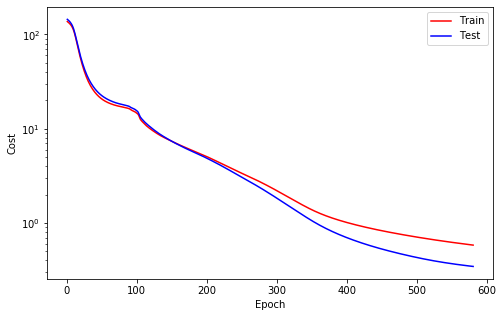



Epoch   581
Train_cost  = 0.5801 | Test_cost  = 0.3445 | 




Epoch   582
Train_cost  = 0.5788 | Test_cost  = 0.3438 | 




Epoch   583
Train_cost  = 0.5776 | Test_cost  = 0.3432 | 




Epoch   584
Train_cost  = 0.5764 | Test_cost  = 0.3425 | 




Epoch   585
Train_cost  = 0.5752 | Test_cost  = 0.3419 | 




Epoch   586
Train_cost  = 0.5740 | Test_cost  = 0.3412 | 




Epoch   587
Train_cost  = 0.5728 | Test_cost  = 0.3406 | 




Epoch   588
Train_cost  = 0.5716 | Test_cost  = 0.3400 | 




Epoch   589
Train_cost  = 0.5704 | Test_cost  = 0.3393 | 




Epoch   590
Train_cost  = 0.5692 | Test_cost  = 0.3387 | 




Epoch   591
Train_cost  = 0.5680 | Test_cost  = 0.3381 | 




Epoch   592
Train_cost  = 0.5668 | Test_cost  = 0.3375 | 




Epoch   593
Train_cost  = 0.5656 | Test_cost  = 0.3369 | 




Epoch   594
Train_cost  = 0.5645 | Test_cost  = 0.3363 | 




Epoch   595
Train_cost  = 0.5633 | Test_cost  = 0.3357 | 




Epoch   596
Train_cost  = 0.5622 | Test_cost  = 0.3352 | 




Epoch   597
Train_cost  = 0.5610 | Test_cost  = 0.3346 | 




Epoch   598
Train_cost  = 0.5599 | Test_cost  = 0.3340 | 




Epoch   599
Train_cost  = 0.5587 | Test_cost  = 0.3335 | 




Epoch   600
Train_cost  = 0.5576 | Test_cost  = 0.3329 | 


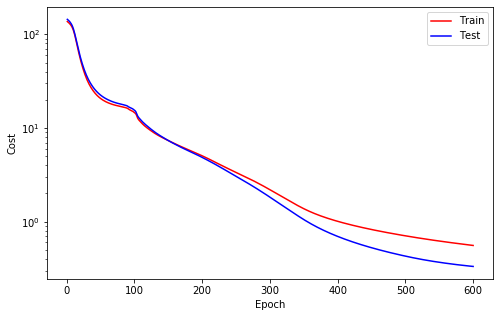



Epoch   601
Train_cost  = 0.5565 | Test_cost  = 0.3324 | 




Epoch   602
Train_cost  = 0.5554 | Test_cost  = 0.3318 | 




Epoch   603
Train_cost  = 0.5543 | Test_cost  = 0.3313 | 




Epoch   604
Train_cost  = 0.5531 | Test_cost  = 0.3308 | 




Epoch   605
Train_cost  = 0.5520 | Test_cost  = 0.3303 | 




Epoch   606
Train_cost  = 0.5509 | Test_cost  = 0.3297 | 




Epoch   607
Train_cost  = 0.5498 | Test_cost  = 0.3292 | 




Epoch   608
Train_cost  = 0.5487 | Test_cost  = 0.3287 | 




Epoch   609
Train_cost  = 0.5477 | Test_cost  = 0.3282 | 




Epoch   610
Train_cost  = 0.5466 | Test_cost  = 0.3278 | 




Epoch   611
Train_cost  = 0.5455 | Test_cost  = 0.3273 | 




Epoch   612
Train_cost  = 0.5444 | Test_cost  = 0.3268 | 




Epoch   613
Train_cost  = 0.5434 | Test_cost  = 0.3263 | 




Epoch   614
Train_cost  = 0.5423 | Test_cost  = 0.3259 | 




Epoch   615
Train_cost  = 0.5412 | Test_cost  = 0.3254 | 




Epoch   616
Train_cost  = 0.5402 | Test_cost  = 0.3250 | 




Epoch   617
Train_cost  = 0.5391 | Test_cost  = 0.3245 | 




Epoch   618
Train_cost  = 0.5381 | Test_cost  = 0.3241 | 




Epoch   619
Train_cost  = 0.5371 | Test_cost  = 0.3236 | 




Epoch   620
Train_cost  = 0.5360 | Test_cost  = 0.3232 | 


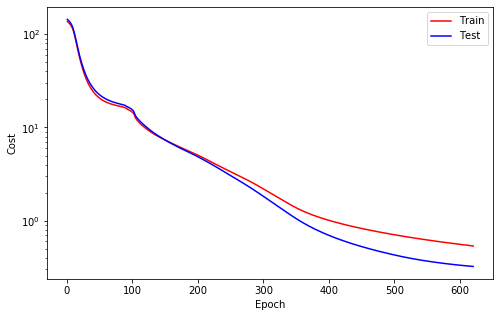



Epoch   621
Train_cost  = 0.5350 | Test_cost  = 0.3228 | 




Epoch   622
Train_cost  = 0.5340 | Test_cost  = 0.3224 | 




Epoch   623
Train_cost  = 0.5329 | Test_cost  = 0.3219 | 




Epoch   624
Train_cost  = 0.5319 | Test_cost  = 0.3215 | 




Epoch   625
Train_cost  = 0.5309 | Test_cost  = 0.3211 | 




Epoch   626
Train_cost  = 0.5299 | Test_cost  = 0.3207 | 




Epoch   627
Train_cost  = 0.5289 | Test_cost  = 0.3204 | 




Epoch   628
Train_cost  = 0.5279 | Test_cost  = 0.3200 | 




Epoch   629
Train_cost  = 0.5269 | Test_cost  = 0.3196 | 




Epoch   630
Train_cost  = 0.5259 | Test_cost  = 0.3192 | 




Epoch   631
Train_cost  = 0.5249 | Test_cost  = 0.3189 | 




Epoch   632
Train_cost  = 0.5239 | Test_cost  = 0.3185 | 




Epoch   633
Train_cost  = 0.5229 | Test_cost  = 0.3181 | 




Epoch   634
Train_cost  = 0.5219 | Test_cost  = 0.3178 | 




Epoch   635
Train_cost  = 0.5209 | Test_cost  = 0.3174 | 




Epoch   636
Train_cost  = 0.5199 | Test_cost  = 0.3171 | 




Epoch   637
Train_cost  = 0.5189 | Test_cost  = 0.3168 | 




Epoch   638
Train_cost  = 0.5180 | Test_cost  = 0.3164 | 




Epoch   639
Train_cost  = 0.5170 | Test_cost  = 0.3161 | 




Epoch   640
Train_cost  = 0.5160 | Test_cost  = 0.3158 | 


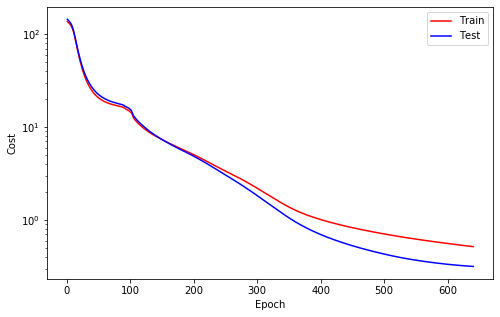



Epoch   641
Train_cost  = 0.5151 | Test_cost  = 0.3155 | 




Epoch   642
Train_cost  = 0.5141 | Test_cost  = 0.3152 | 




Epoch   643
Train_cost  = 0.5132 | Test_cost  = 0.3148 | 




Epoch   644
Train_cost  = 0.5122 | Test_cost  = 0.3145 | 




Epoch   645
Train_cost  = 0.5113 | Test_cost  = 0.3142 | 




Epoch   646
Train_cost  = 0.5103 | Test_cost  = 0.3140 | 




Epoch   647
Train_cost  = 0.5094 | Test_cost  = 0.3137 | 




Epoch   648
Train_cost  = 0.5084 | Test_cost  = 0.3134 | 




Epoch   649
Train_cost  = 0.5075 | Test_cost  = 0.3131 | 




Epoch   650
Train_cost  = 0.5065 | Test_cost  = 0.3128 | 




Epoch   651
Train_cost  = 0.5056 | Test_cost  = 0.3126 | 




Epoch   652
Train_cost  = 0.5047 | Test_cost  = 0.3123 | 




Epoch   653
Train_cost  = 0.5038 | Test_cost  = 0.3120 | 




Epoch   654
Train_cost  = 0.5028 | Test_cost  = 0.3118 | 




Epoch   655
Train_cost  = 0.5019 | Test_cost  = 0.3115 | 




Epoch   656
Train_cost  = 0.5010 | Test_cost  = 0.3113 | 




Epoch   657
Train_cost  = 0.5001 | Test_cost  = 0.3110 | 




Epoch   658
Train_cost  = 0.4992 | Test_cost  = 0.3108 | 




Epoch   659
Train_cost  = 0.4983 | Test_cost  = 0.3106 | 




Epoch   660
Train_cost  = 0.4974 | Test_cost  = 0.3103 | 


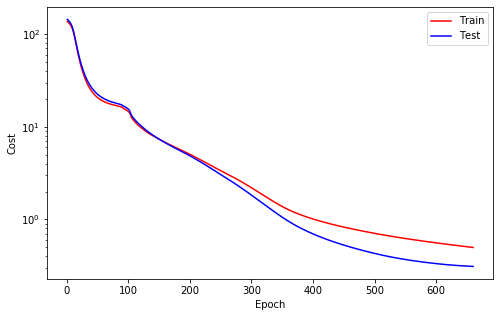



Epoch   661
Train_cost  = 0.4965 | Test_cost  = 0.3101 | 




Epoch   662
Train_cost  = 0.4956 | Test_cost  = 0.3099 | 




Epoch   663
Train_cost  = 0.4947 | Test_cost  = 0.3097 | 




Epoch   664
Train_cost  = 0.4938 | Test_cost  = 0.3095 | 




Epoch   665
Train_cost  = 0.4929 | Test_cost  = 0.3093 | 




Epoch   666
Train_cost  = 0.4920 | Test_cost  = 0.3091 | 




Epoch   667
Train_cost  = 0.4911 | Test_cost  = 0.3089 | 




Epoch   668
Train_cost  = 0.4902 | Test_cost  = 0.3087 | 




Epoch   669
Train_cost  = 0.4894 | Test_cost  = 0.3085 | 




Epoch   670
Train_cost  = 0.4885 | Test_cost  = 0.3083 | 




Epoch   671
Train_cost  = 0.4876 | Test_cost  = 0.3081 | 




Epoch   672
Train_cost  = 0.4867 | Test_cost  = 0.3080 | 




Epoch   673
Train_cost  = 0.4859 | Test_cost  = 0.3078 | 




Epoch   674
Train_cost  = 0.4850 | Test_cost  = 0.3077 | 




Epoch   675
Train_cost  = 0.4841 | Test_cost  = 0.3075 | 




Epoch   676
Train_cost  = 0.4833 | Test_cost  = 0.3074 | 




Epoch   677
Train_cost  = 0.4824 | Test_cost  = 0.3072 | 




Epoch   678
Train_cost  = 0.4815 | Test_cost  = 0.3071 | 




Epoch   679
Train_cost  = 0.4807 | Test_cost  = 0.3070 | 




Epoch   680
Train_cost  = 0.4798 | Test_cost  = 0.3069 | 


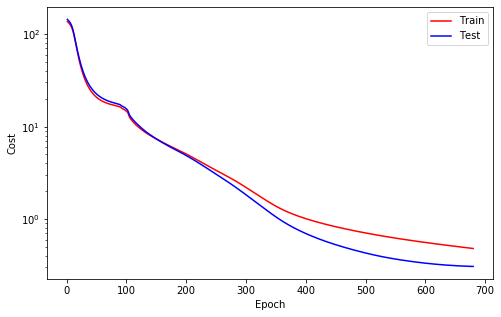



Epoch   681
Train_cost  = 0.4790 | Test_cost  = 0.3067 | 




Epoch   682
Train_cost  = 0.4781 | Test_cost  = 0.3066 | 




Epoch   683
Train_cost  = 0.4773 | Test_cost  = 0.3065 | 




Epoch   684
Train_cost  = 0.4764 | Test_cost  = 0.3065 | 




Epoch   685
Train_cost  = 0.4756 | Test_cost  = 0.3064 | 




Epoch   686
Train_cost  = 0.4748 | Test_cost  = 0.3063 | 




Epoch   687
Train_cost  = 0.4739 | Test_cost  = 0.3062 | 




Epoch   688
Train_cost  = 0.4731 | Test_cost  = 0.3062 | 




Epoch   689
Train_cost  = 0.4722 | Test_cost  = 0.3061 | 




Epoch   690
Train_cost  = 0.4714 | Test_cost  = 0.3061 | 




Epoch   691
Train_cost  = 0.4706 | Test_cost  = 0.3060 | 




Epoch   692
Train_cost  = 0.4698 | Test_cost  = 0.3060 | 




Epoch   693
Train_cost  = 0.4689 | Test_cost  = 0.3059 | 




Epoch   694
Train_cost  = 0.4681 | Test_cost  = 0.3059 | 




Epoch   695
Train_cost  = 0.4673 | Test_cost  = 0.3059 | 




Epoch   696
Train_cost  = 0.4665 | Test_cost  = 0.3059 | 




Epoch   697
Train_cost  = 0.4657 | Test_cost  = 0.3059 | 




Epoch   698
Train_cost  = 0.4649 | Test_cost  = 0.3059 | 




Epoch   699
Train_cost  = 0.4641 | Test_cost  = 0.3059 | 
==> EarlyStop patience =  1 | Best test_cost: 0.3059




Epoch   700
Train_cost  = 0.4633 | Test_cost  = 0.3059 | 


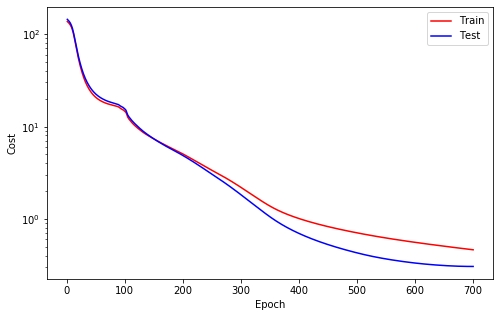

==> EarlyStop patience =  2 | Best test_cost: 0.3059




Epoch   701
Train_cost  = 0.4625 | Test_cost  = 0.3059 | 
==> EarlyStop patience =  3 | Best test_cost: 0.3059




Epoch   702
Train_cost  = 0.4617 | Test_cost  = 0.3059 | 
==> EarlyStop patience =  4 | Best test_cost: 0.3059




Epoch   703
Train_cost  = 0.4609 | Test_cost  = 0.3059 | 
==> EarlyStop patience =  5 | Best test_cost: 0.3059
==> Execute Early Stopping at epoch: 703 | Best test_cost: 0.3059
==> Best model is saved at model/bilstm


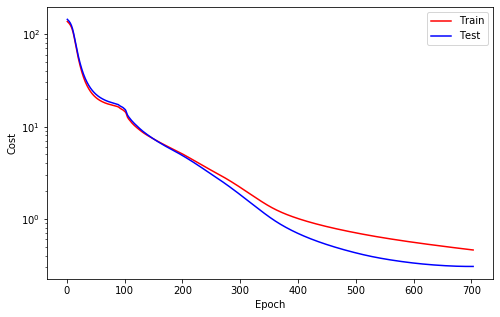

In [25]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [26]:
from luwiji.rnn import illustration

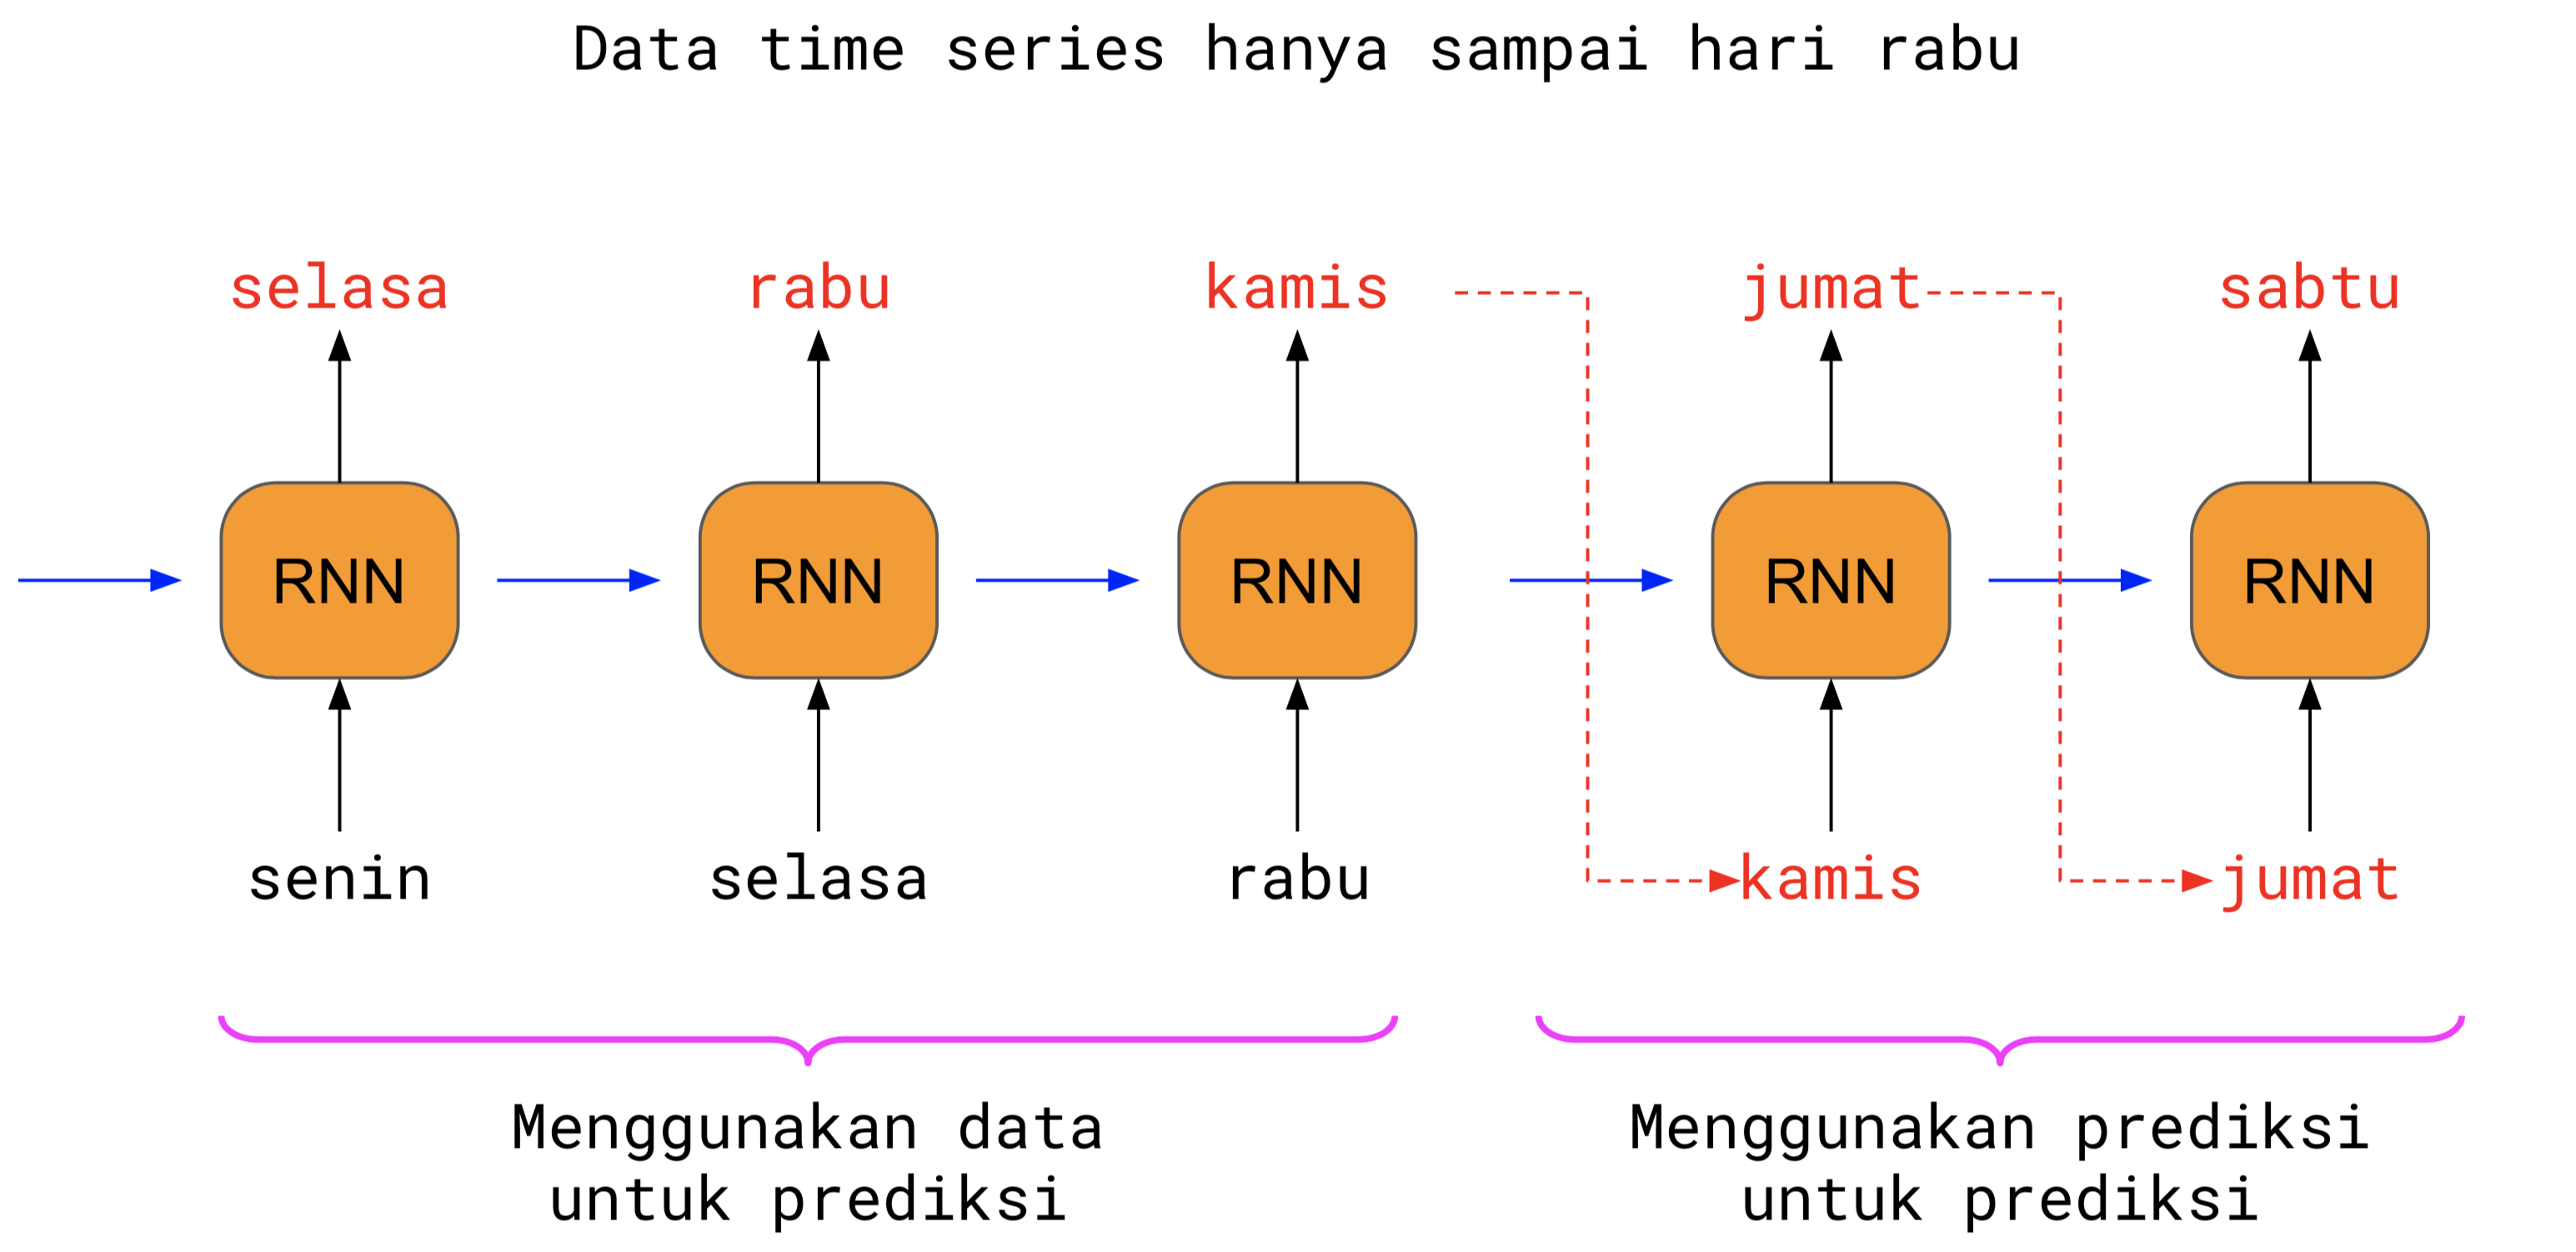

In [27]:
illustration.forecast

In [28]:
from utils import data4pred, pred4pred

In [29]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

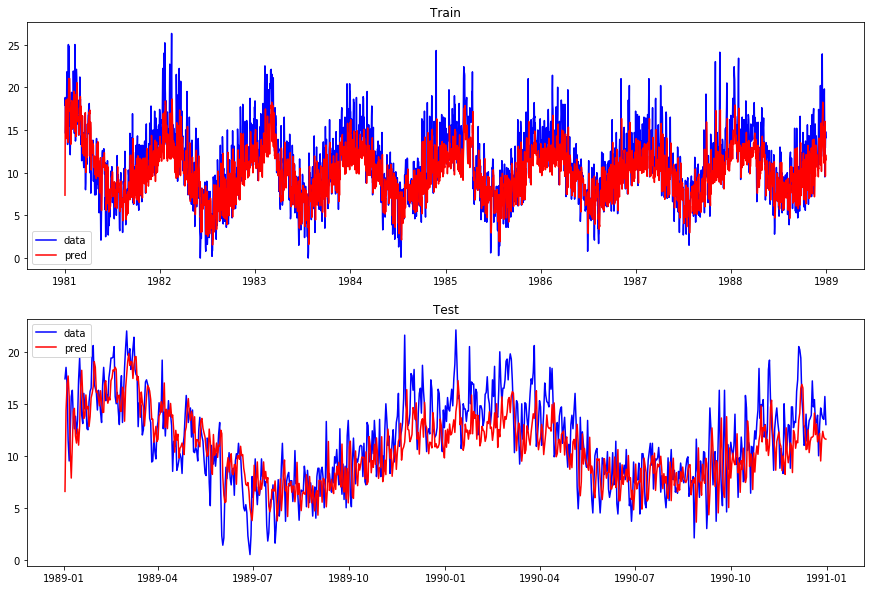

In [30]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

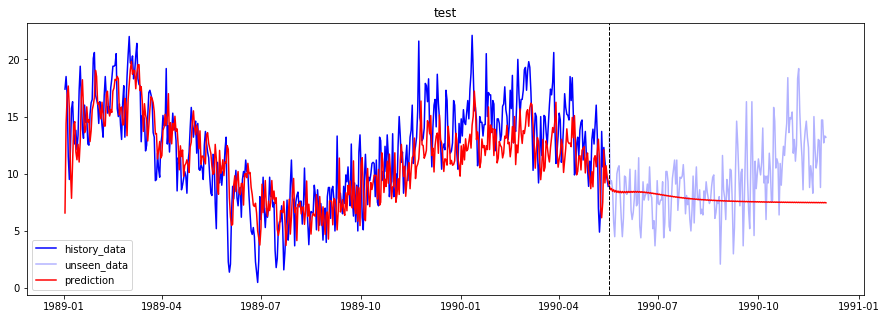

In [31]:
#Pred 4 pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")